In [1]:
# import libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

import os
import csv

import statsmodels.api as sm
import geopandas as gpd
import shapely

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#  upload geojson with neighborhood boundaries
neighbor = gpd.GeoDataFrame.from_file('../geo/neighborhoods.geojson')

#  upload table with conversion between census tract and zip code
census = pd.read_csv('../geo/census_zip.csv')

#  upload table with conversion between zip code and neighborhood
comm = pd.read_csv('../geo/zip_comm.csv')

In [3]:
#  convert cols to str for merge

comm['ZCTA5'] = comm['ZCTA5'].astype('int').astype('str')
comm['CHGOCA'] = comm['CHGOCA'].astype('int').astype('str')
census['zip'] = census['zip'].astype('int').astype('str')
census['tract'] = census['tract'].astype('str')

In [4]:
#  list of names of mental health (mh) data tables
data = ['EMSOD','HCSBDP','HCSBHP','HCSNVP',
             'HCSSPDP','HDBHR','HDDRR','HDSZR',
        'MEODR','YRDEP','VRALR','VRDIDR', 'VRDOR', 'VRSUR']

In [5]:
#  concatenate mh data tables  
files = [f'../data/{file}.csv' for file in data]
mh = pd.concat(map(pd.read_csv, files),axis = 0)

#  select statistics for entire pop (not by demographic subgroup) 
mh = mh[mh['p'].isnull()]

#  omit rows which aggregate all neighborhoods
mh = mh[mh['l'] != 'place']

#  convert neighborhood ID to str for merge
mh['g'] = mh['g'].astype('str')

#  merge mh tables to convert zip codes to neighborhood codes
mh = mh.merge(comm, how = 'left', left_on = 'g', right_on = 'ZCTA5')

In [6]:
mh.loc[mh['g'].str.len() == 5,'g'] = mh['CHGOCA']

#  delete city code where it precedes the neighborhood code
mh['g'] = mh['g'].str.replace('1714000-','')

In [7]:
#  merge neighborhood geojson with mh data
neighbor = neighbor.merge(mh, how = 'left', left_on = 'area_numbe', right_on = 'g')

In [8]:
#  create feature for lat/long based on the centroids of neighborhoods in geojson
neighbor['long'] = neighbor['geometry'].centroid.x
neighbor['lat'] = neighbor['geometry'].centroid.y

C:\Users\Finley & Stein\AppData\Local\Temp\ipykernel_12116\2077965834.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  neighbor['long'] = neighbor['geometry'].centroid.x
C:\Users\Finley & Stein\AppData\Local\Temp\ipykernel_12116\2077965834.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  neighbor['lat'] = neighbor['geometry'].centroid.y


In [9]:
#  convert columns to str for merge
neighbor['g'] = neighbor['g'].astype('int').astype('str')
neighbor['d'] = neighbor['d'].astype('str')

In [10]:
#  view merged df
neighbor.head()

,community,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,geometry,...,a,p,d,v,Unnamed: 0,ZCTA5,CHGOCA,TOT2010,long,lat
0,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ...",...,EMSOD,NaN,2021,130.0,NaN,NaN,NaN,NaN,-87.618678,41.835118
1,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ...",...,EMSOD,NaN,2020,155.0,NaN,NaN,NaN,NaN,-87.618678,41.835118
2,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ...",...,EMSOD,NaN,2019,124.0,NaN,NaN,NaN,NaN,-87.618678,41.835118
3,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ...",...,EMSOD,NaN,2018,88.0,NaN,NaN,NaN,NaN,-87.618678,41.835118
4,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ...",...,EMSOD,NaN,2017,144.0,NaN,NaN,NaN,NaN,-87.618678,41.835118


In [11]:
#  view columns
neighbor.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 7278 entries, 0 to 7277
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   community   7278 non-null   object  
 1   area        7278 non-null   object  
 2   shape_area  7278 non-null   object  
 3   perimeter   7278 non-null   object  
 4   area_num_1  7278 non-null   object  
 5   area_numbe  7278 non-null   object  
 6   comarea_id  7278 non-null   object  
 7   comarea     7278 non-null   object  
 8   shape_len   7278 non-null   object  
 9   geometry    7278 non-null   geometry
 10  se          6555 non-null   float64 
 11  g           7278 non-null   object  
 12  l           7278 non-null   object  
 13  a           7278 non-null   object  
 14  p           0 non-null      object  
 15  d           7278 non-null   object  
 16  v           7278 non-null   float64 
 17  Unnamed: 0  4585 non-null   float64 
 18  ZCTA5       4585 non-null   object  
 19

In [20]:
crime = {}
files = ['CZA','CZB','CZD','CZH','CZL','CZM','CZO','CZP','CZR','CZS','CZT','CZV']

In [21]:
for file in files:
    path = f'../data/{file}.csv'
    
    if os.path.isfile(path):
        crime[file] = pd.read_csv(path)

In [22]:
#  function to convert crime data index: census tract -> zip -> neighborhood code
#  function merges with neighborhood df on g (neighborhood) and d (year), then renames columns
def transform(df):
    df.drop(df[df['p'].notnull()].index, inplace = True)
    df.drop(df[df['l'] == 'place'].index, inplace = True)

    df = df.merge(census, how = 'left', left_on = 'g', right_on = 'tract')
    df['zip'] = df['zip'].astype('str')
    df.loc[df['l'] == 'tract-2010','g'] = df['zip']

    df = df.merge(comm, how = 'left', left_on = 'g', right_on = 'ZCTA5')
    df['zip'] = df['zip'].astype('str')
    df.loc[df['l'] == 'tract-2010','g'] = df['zip']

    df.loc[df['g'].str.len() == 5,'g'] = df['CHGOCA']
    df['g'] = df['g'].str.replace('1714000-','')    
    
    df = neighbor.merge(df, how = 'left', left_on = ['g','d'], right_on = ['g','d'])
    df.dropna(subset = 'v_y',inplace = True)
    df.rename(columns = {'a_x':'mh_stat','v_x':'mh_val','v_y':'crim_val'}, inplace = True)
    return df

In [76]:
#  create empty lists for MSEs
mse = []

for stat in [CZA, CZB, CZD, CZH, CZL, CZM, CZO, CZP, CZR, CZS, CZT, CZV]:
    
    #  create df for each crim stat including values for crim stat and mh stats by neighborhood
    X = transform(crime[f'{stat}'])[['mh_stat','mh_val','lat','long','d','crim_val']]
    
    #  create column with avg value of crim stat for neighborhood
    avgs = X.groupby(['mh_stat','mh_val','lat','long'])['crim_val'].agg('mean')
    X['crim_val'] = X.groupby(['mh_stat','mh_val','lat','long'])['crim_val'].transform(lambda x: avgs[x.name])
    
    y = X['crim_val']
    X = X.drop(columns = ['crim_val','d'])
    
    #  dummify mh stat columns
    X = pd.get_dummies(X, columns = ['mh_stat'])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
    
    #  calculate baseline MSE
    base = [np.mean(y_train)] * len(y_test)
    baseline = mean_squared_error(y_test, base, squared=False)
    
    #  train models and evaluate MSE: Linear Regression, Lasso, Ridge, KNeighbors, 
    #                                Decision Tree, Random Forest, AdaBoost
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_train = mean_squared_error(y_train, lr.predict(X_train), squared=False)
    lr_test = mean_squared_error(y_test, lr.predict(X_test), squared=False)
    print(('lr',lr_train,lr_test))
    
    lasso = Lasso()
    lasso.fit(X_train, y_train)
    lasso_train = mean_squared_error(y_train,lasso.predict(X_train), squared = False)
    lasso_test = mean_squared_error(y_test, lasso.predict(X_test), squared=False)
    print(('lasso',lasso_train, lasso_test))
    
    rg = Ridge()
    rg.fit(X_train, y_train)
    rg_train = mean_squared_error(y_train,rg.predict(X_train), squared = False) 
    rg_test = mean_squared_error(y_test, rg.predict(X_test), squared=False)
    print(('rg',rg_train,rg_test))
    
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)
    knn_train = mean_squared_error(y_train,knn.predict(X_train), squared = False)
    knn_test = mean_squared_error(y_test, knn.predict(X_test), squared=False)
    print(('knn',knn_train,knn_test))

    dt = DecisionTreeRegressor()
    dt.fit(X_train, y_train)
    dt_train = mean_squared_error(y_train,dt.predict(X_train), squared = False) 
    dt_test = mean_squared_error(y_test, dt.predict(X_test), squared=False)
    print(('dt',dt_train,dt_test))

    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    rf_train = mean_squared_error(y_train,rf.predict(X_train), squared = False)
    rf_test = mean_squared_error(y_test, rf.predict(X_test), squared=False)
    print(('rf',rf_train,rf_test))

    abr = AdaBoostRegressor()
    abr.fit(X_train, y_train)
    abr_train = mean_squared_error(y_train,abr.predict(X_train), squared = False)
    abr_test = mean_squared_error(y_test, abr.predict(X_test), squared=False)
    print(('abr',abr_train,abr_test))
    print('\n')
    mse.append([baseline, lr_train, lr_test, lasso_train, lasso_test, rg_train, rg_test, knn_train, knn_test, 
                   dt_train, dt_test, rf_train, rf_test, abr_train, abr_test])
mse

('lr', 11.224784650224496, 11.27160089271829)
('lasso', 11.543187620489153, 11.633764036807483)
('rg', 11.224762738257068, 11.271663271541925)
('knn', 1.96069107281691e-15, 1.982047248146232e-15)
('dt', 4.9618382914296916e-14, 4.930041130887249e-14)
('rf', 9.391403587371342e-05, 0.00013549465586216406)
('abr', 5.678570383884539, 5.708423994790681)


('lr', 7.545676860313719, 7.5542634312811385)
('lasso', 8.039218446748665, 8.050730307033312)
('rg', 7.545640646036586, 7.554162133925842)
('knn', 1.1870808241547624e-15, 1.2035921128211091e-15)
('dt', 5.575531921105548e-14, 5.4347887279483e-14)
('rf', 0.0001475519176010229, 0.00020866870542156186)
('abr', 5.822939968168838, 5.827083796457348)


('lr', 24.846713761006562, 25.10872481261183)
('lasso', 25.090735337517177, 25.38720137097821)
('rg', 24.846713662620232, 25.10869449565261)
('knn', 1.5706062631186426e-15, 1.57730126635601e-15)
('dt', 8.56092183942817e-14, 8.67960111746124e-14)
('rf', 0.00013270090686100412, 0.0001864125572698631)


[[18.02935508185535,
  11.224784650224496,
  11.27160089271829,
  11.543187620489153,
  11.633764036807483,
  11.224762738257068,
  11.271663271541925,
  1.96069107281691e-15,
  1.982047248146232e-15,
  4.9618382914296916e-14,
  4.930041130887249e-14,
  9.391403587371342e-05,
  0.00013549465586216406,
  5.678570383884539,
  5.708423994790681],
 [10.652554402317307,
  7.545676860313719,
  7.5542634312811385,
  8.039218446748665,
  8.050730307033312,
  7.545640646036586,
  7.554162133925842,
  1.1870808241547624e-15,
  1.2035921128211091e-15,
  5.575531921105548e-14,
  5.4347887279483e-14,
  0.0001475519176010229,
  0.00020866870542156186,
  5.822939968168838,
  5.827083796457348],
 [29.098807346284033,
  24.846713761006562,
  25.10872481261183,
  25.090735337517177,
  25.38720137097821,
  24.846713662620232,
  25.10869449565261,
  1.5706062631186426e-15,
  1.57730126635601e-15,
  8.56092183942817e-14,
  8.67960111746124e-14,
  0.00013270090686100412,
  0.0001864125572698631,
  11.063134

In [84]:
pd.DataFrame(mse).T.describe()

,0,1,2,3,4,5,6,7,8,9,10,11
count,1.500000e+01,1.500000e+01,1.500000e+01,1.500000e+01,1.500000e+01,1.500000e+01,1.500000e+01,1.500000e+01,1.500000e+01,1.500000e+01,1.500000e+01,1.500000e+01
mean,6.505756e+00,4.572842e+00,1.344909e+01,5.275083e-01,4.610235e+01,5.001858e+01,2.770613e-01,5.021992e+01,4.921541e+00,6.355329e-01,3.686554e+00,1.139855e+01
std,6.151057e+00,4.010029e+00,1.239453e+01,4.801997e-01,4.296304e+01,4.678143e+01,2.449548e-01,4.617925e+01,4.452240e+00,5.838559e-01,3.278053e+00,1.069753e+01
min,1.960691e-15,1.187081e-15,1.570606e-15,7.800474e-17,6.294410e-15,8.641401e-15,1.808318e-15,1.032424e-14,1.000192e-15,5.662368e-15,4.849502e-14,3.452399e-15
25%,4.695702e-05,7.377596e-05,6.635045e-05,5.522602e-05,9.618405e-04,7.645216e-04,7.147106e-04,4.108773e-04,1.864818e-05,7.186980e-04,1.694769e-03,1.059676e-04
50%,5.708424e+00,5.827084e+00,1.118532e+01,6.449782e-01,3.494350e+01,3.683083e+01,3.930597e-01,4.154440e+01,4.858191e+00,5.766019e-01,3.950793e+00,9.936499e+00
75%,1.127163e+01,7.554213e+00,2.509971e+01,7.678430e-01,8.827640e+01,9.572012e+01,4.024878e-01,9.485082e+01,8.669552e+00,1.075816e+00,6.399442e+00,2.007309e+01
max,1.802936e+01,1.065255e+01,2.909881e+01,1.189030e+00,9.247843e+01,1.024188e+02,5.912487e-01,1.014132e+02,1.148824e+01,1.362196e+00,8.043216e+00,3.040075e+01


Although Decision Tree and Random Forest performed better, Lasso and Ridge have the advantage in explainability by providing a coefficient for each feature.  We can tune parameters for either Lasso or Ridge by using ElasticNet.

In [18]:
#  perform GridSearch to find best hyperparameters for ElasticNet
for stat in ['CZA', 'CZB', 'CZD', 'CZH', 'CZL', 'CZM', 'CZO', 'CZP', 'CZR', 'CZS', 'CZT', 'CZV']:
    
    X = transform(crime[stat])[['mh_stat','mh_val','lat','long','d','crim_val']]
    avgs = X.groupby(['mh_stat','mh_val','lat','long'])['crim_val'].agg('mean')
    X['crim_val'] = X.groupby(['mh_stat','mh_val','lat','long'])['crim_val'].transform(lambda x: avgs[x.name])
    
    y = X['crim_val']
    X = X.drop(columns = ['crim_val','d'])
    
    X = pd.get_dummies(X, columns = ['mh_stat'])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
    
    gs = GridSearchCV(ElasticNet(),
                      param_grid = {'alpha':[0.01,0.1,1,10,100],
                                    'l1_ratio':[0.01,0.1,0.25,0.5,0.9,0.99]
                      },
                      cv = 5,
                      verbose = 1,
                      n_jobs = -1
                     )
    gs.fit(X_train, y_train)
    print(stat,gs.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
CZA {'alpha': 0.01, 'l1_ratio': 0.99}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
CZB {'alpha': 0.01, 'l1_ratio': 0.99}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
CZD {'alpha': 0.01, 'l1_ratio': 0.99}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
CZH {'alpha': 0.01, 'l1_ratio': 0.01}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
CZL {'alpha': 0.01, 'l1_ratio': 0.99}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
CZM {'alpha': 0.01, 'l1_ratio': 0.99}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
CZO {'alpha': 0.01, 'l1_ratio': 0.01}
Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.004e+07, tolerance: 1.566e+05
  model = cd_fast.enet_coordinate_descent(


CZP {'alpha': 0.01, 'l1_ratio': 0.99}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
CZR {'alpha': 0.01, 'l1_ratio': 0.99}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
CZS {'alpha': 0.01, 'l1_ratio': 0.01}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
CZT {'alpha': 0.01, 'l1_ratio': 0.99}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
CZV {'alpha': 0.01, 'l1_ratio': 0.99}


The GridSearch returned l1 ratios of 0.99 for almost every stat.  This suggests that only l1 regularization is required, so we will tune Lasso.

In [23]:
#  perform GridSearch to check best hyperparameters for Lasso
for stat in ['CZA', 'CZB', 'CZD', 'CZH', 'CZL', 'CZM', 'CZO', 'CZP', 'CZR', 'CZS', 'CZT', 'CZV']:
    
    X = transform(crime[stat])[['mh_stat','mh_val','lat','long','d','crim_val']]
    avgs = X.groupby(['mh_stat','mh_val','lat','long'])['crim_val'].agg('mean')
    X['crim_val'] = X.groupby(['mh_stat','mh_val','lat','long'])['crim_val'].transform(lambda x: avgs[x.name])
    
    y = X['crim_val']
    X = X.drop(columns = ['crim_val','d'])
    
    X = pd.get_dummies(X, columns = ['mh_stat'])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
    
    gs = GridSearchCV(Lasso(),
                      param_grid = {'alpha':[0.001,0.005,0.01,0.02,0.05]
                      },
                      cv = 5,
                      verbose = 1,
                      n_jobs = -1
                     )
    gs.fit(X_train, y_train)
    print(stat,gs.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CZA {'alpha': 0.005}
Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.712e+05, tolerance: 1.937e+03
  model = cd_fast.enet_coordinate_descent(


CZB {'alpha': 0.001}
Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.647e+06, tolerance: 1.401e+04
  model = cd_fast.enet_coordinate_descent(


CZD {'alpha': 0.001}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
CZH {'alpha': 0.001}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
CZL {'alpha': 0.005}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
CZM {'alpha': 0.05}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
CZO {'alpha': 0.001}
Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.122e+07, tolerance: 1.566e+05
  model = cd_fast.enet_coordinate_descent(


CZP {'alpha': 0.02}
Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.521e+05, tolerance: 2.248e+03
  model = cd_fast.enet_coordinate_descent(


CZR {'alpha': 0.001}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
CZS {'alpha': 0.001}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
CZT {'alpha': 0.001}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
CZV {'alpha': 0.001}


C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.533e+05, tolerance: 1.426e+04
  model = cd_fast.enet_coordinate_descent(


0.001 is the best value of alpha for most stats.  The model appears to need some regularization (since lasso is still outperforming linear regression), but not very much.

In [33]:
#  determine how much of variance in crim stats are explained by mh stats by using R^2 score
#  create empty lists for mh stat value and R^2 score
values = []
errors = []
for stat in ['CZA', 'CZB', 'CZD', 'CZH', 'CZL', 'CZM', 'CZO', 'CZP', 'CZR', 'CZS', 'CZT', 'CZV']:
    
    X = transform(crime[stat])[['mh_stat','mh_val','lat','long','d','crim_val']]
    avgs = X.groupby(['mh_stat','mh_val','lat','long'])['crim_val'].agg('mean')
    X['crim_val'] = X.groupby(['mh_stat','mh_val','lat','long'])['crim_val'].transform(lambda x: avgs[x.name])
    
    y = X['crim_val']
    X = X.drop(columns = ['crim_val','d'])
    
    X = pd.get_dummies(X, columns = ['mh_stat'])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
    
    
    base = [np.mean(y_train)] * len(y_test)
    baseline = r2_score(y_test, base)                              
       
    lasso = Lasso(alpha = 0.001)
    lasso.fit(X_train, y_train)
    lasso_train = r2_score(y_train,lasso.predict(X_train))
    lasso_test = r2_score(y_test, lasso.predict(X_test))
    
    print(baseline,lasso_train,lasso_test)
    values.append(lasso.coef_)
    errors.append(lasso_test)

-9.628800692995654e-06 0.6077107941332069 0.6091379443689493


C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.712e+05, tolerance: 1.937e+03
  model = cd_fast.enet_coordinate_descent(


-1.6544345770919122e-05 0.4961468484184588 0.4971084674113764


C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.647e+06, tolerance: 1.401e+04
  model = cd_fast.enet_coordinate_descent(


-1.0458705796745349e-05 0.24860881673289326 0.25543379776277475
-1.4277560269615464e-06 0.5817344352265077 0.5829754911753944


C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.814e+07, tolerance: 1.544e+05
  model = cd_fast.enet_coordinate_descent(


-9.548089199729048e-06 0.112186168976106 0.11249847723520567


C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.644e+07, tolerance: 1.515e+05
  model = cd_fast.enet_coordinate_descent(


-5.12726228141247e-08 0.11479632261362105 0.11567425039154844
-1.1679902065520054e-06 0.5529663430324192 0.5580173086724844


C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.119e+07, tolerance: 1.566e+05
  model = cd_fast.enet_coordinate_descent(


-2.584950133499575e-06 0.11878024298016765 0.12169450725196496


C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.521e+05, tolerance: 2.248e+03
  model = cd_fast.enet_coordinate_descent(


-1.6461888452390383e-07 0.43422344936166013 0.43051391661030536
-2.848363538365817e-07 0.37259792441406536 0.38141334584417275
-1.3973358393037927e-05 0.3668003720532933 0.3698763870047047
-1.5896880312782358e-05 0.5641785427710808 0.5656319245126206


C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.533e+05, tolerance: 1.426e+04
  model = cd_fast.enet_coordinate_descent(


In [34]:
#  convert lists to dfs
values = pd.DataFrame(values)
errors = pd.DataFrame(errors)

In [26]:
#  rename values columns as mh stats from model  
values.columns = ss.get_feature_names_out()

In [27]:
#  combine mh stat values and R^2 scores into single df
df = pd.concat([values,errors], axis = 1)

In [28]:
#  rename index to crim stats
df.index = ['CZA', 'CZB', 'CZD', 'CZH', 'CZL', 'CZM', 'CZO', 'CZP', 'CZR', 'CZS', 'CZT', 'CZV']

In [29]:
df

,mh_val,lat,long,mh_stat_EMSOD,mh_stat_HDBHR,mh_stat_HDDRR,mh_stat_HDSZR,mh_stat_MEODR,mh_stat_VRALR,mh_stat_VRDIDR,mh_stat_VRDOR,mh_stat_VRSUR,0
CZA,5.763857,-13.281510,-0.823070,-1.727686,-2.457737,0.000000,-0.138624,0.000000,0.270104,0.012242,0.012158,0.317288,0.609138
CZB,0.474889,-7.521788,-0.955961,-0.892417,1.619393,1.834786,1.808847,-0.091359,-0.427422,-0.460707,-0.449895,-0.421684,0.497108
CZD,12.753394,-9.620206,-8.815165,-5.119265,-4.859657,0.578633,0.290647,0.054699,0.091082,-0.592898,-0.561423,0.130703,0.255434
CZH,0.374112,-0.931663,-0.210702,-0.077275,-0.102864,0.062148,0.051134,-0.003374,0.016705,-0.000545,0.000000,0.019490,0.582975
CZL,11.450075,18.644787,34.172232,-7.531156,3.112591,3.995008,5.355718,-1.012184,-1.512948,-1.878565,-1.943922,-1.420090,0.112498
CZM,20.977749,-0.188696,26.942495,-8.370531,-0.550158,4.615642,5.737369,-2.552412,-0.583947,-1.267323,-1.209213,-0.561924,0.115674
CZO,0.136573,-0.505480,-0.244647,-0.017203,-0.047422,0.013486,0.008554,-0.010324,0.005146,0.000000,-0.000000,0.006687,0.558017
CZP,14.574152,5.862208,31.674941,-12.547381,1.993656,4.363035,5.761611,-3.914620,-1.674090,-2.054304,-1.930236,-1.505050,0.121695
CZR,3.877239,-5.384561,1.243638,-1.644529,0.322266,1.796532,1.786862,-0.049116,-0.117497,-0.285922,-0.288435,-0.091569,0.430514
CZS,0.415891,-0.536672,0.279946,-0.108935,-0.098960,0.054842,0.053109,-0.000000,0.018231,-0.000240,-0.000000,0.020392,0.381413


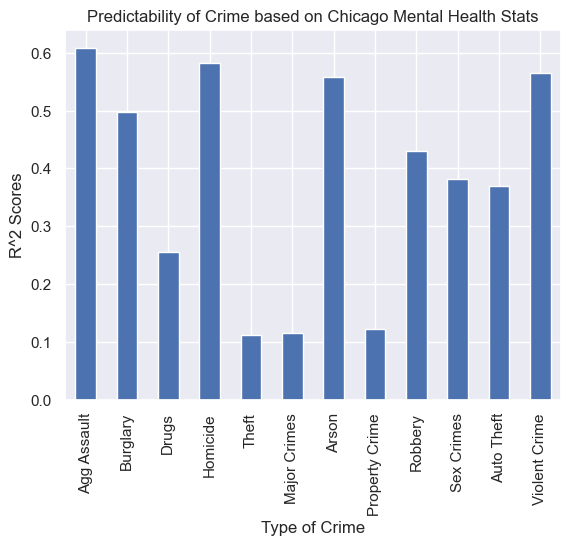

In [35]:
#  plot R^2 score for each crime stat
fig, ax = plt.subplots(1)
ax = df.iloc[:,-1].plot(kind='bar')
ax.set_xticklabels(['Agg Assault','Burglary','Drugs','Homicide',
                    'Theft','Major Crimes','Arson','Property Crime',
                    'Robbery','Sex Crimes','Auto Theft','Violent Crime'], rotation = 90)
ax.set_title('Predictability of Crime based on Chicago Mental Health Stats')
ax.set_ylabel('R^2 Scores')
ax.set_xlabel('Type of Crime');